<a href="https://colab.research.google.com/github/joshuabusinge/deeplearning_chestopacity/blob/main/ChestOpacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pathlib
dataset_1 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/dataset1"
training_ds = tf.keras.utils.image_dataset_from_directory(dataset_1, validation_split=0.2, subset="training", seed=123, image_size=(100, 100), batch_size=20)
# data_dir = pathlib.Path(dataset_1)

Found 715 files belonging to 2 classes.
Using 572 files for training.


In [4]:
class_names = training_ds.class_names
print(class_names)

['normal', 'sick']


In [5]:
valid_ds = tf.keras.utils.image_dataset_from_directory(dataset_1, validation_split=0.2, subset="validation", seed=123, image_size=(100, 100), batch_size=20)


Found 715 files belonging to 2 classes.
Using 143 files for validation.


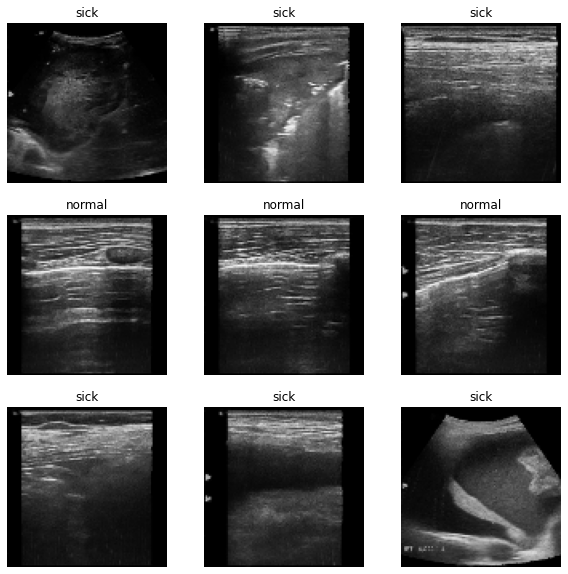

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in training_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 100, 100, 3)
(20,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = training_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[3]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.0 0.9746294


Creating the Model

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the Model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model Summary

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        1

Train the Model

In [14]:
epochs=10
history = model.fit(
  training_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 15s 500ms/step - loss: 0.3826 - accuracy: 0.8269 - val_loss: 0.1864 - val_accuracy: 0.9371
Epoch 2/10
29/29 [==============================] - 6s 209ms/step - loss: 0.1816 - accuracy: 0.9266 - val_loss: 0.1523 - val_accuracy: 0.9580
Epoch 3/10
29/29 [==============================] - 6s 209ms/step - loss: 0.1587 - accuracy: 0.9336 - val_loss: 0.1999 - val_accuracy: 0.9301
Epoch 4/10
29/29 [==============================] - 6s 209ms/step - loss: 0.1186 - accuracy: 0.9563 - val_loss: 0.1411 - val_accuracy: 0.9510
Epoch 5/10
29/29 [==============================] - 6s 209ms/step - loss: 0.0686 - accuracy: 0.9773 - val_loss: 0.1194 - val_accuracy: 0.9580
Epoch 6/10
29/29 [==============================] - 6s 210ms/step - loss: 0.0479 - accuracy: 0.9843 - val_loss: 0.1623 - val_accuracy: 0.9441
Epoch 7/10
29/29 [==============================] - 6s 205ms/step - loss: 0.0496 - accuracy: 0.9860 - val_loss: 0.0984 - val_accuracy: 0.9580
Epoch

Visualize training results

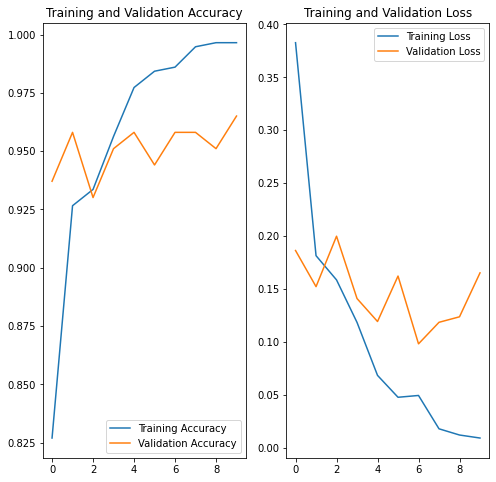

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
valid_loss,valid_acc = model.evaluate(valid_ds)
print(valid_loss)
print(valid_acc)

training_loss,training_acc = model.evaluate(training_ds)
print(training_loss)
print(training_acc)


8/8 [==============================] - 0s 54ms/step - loss: 0.1653 - accuracy: 0.9650
0.165330171585083
0.9650349617004395
29/29 [==============================] - 2s 61ms/step - loss: 0.0071 - accuracy: 0.9965
0.00711877690628171
0.996503472328186


Data augmentation

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(100,
                                  100,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

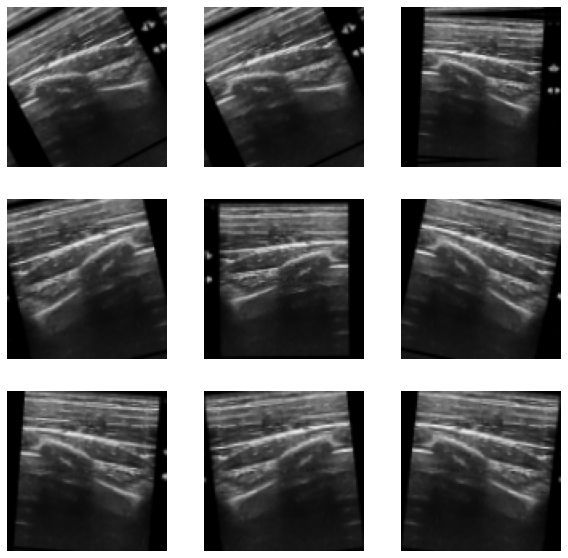

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Dropout

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

In [22]:
epochs = 15
history = model.fit(
  training_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/15
29/29 [==============================] - 8s 244ms/step - loss: 0.5023 - accuracy: 0.7378 - val_loss: 0.4445 - val_accuracy: 0.8042
Epoch 2/15
29/29 [==============================] - 8s 276ms/step - loss: 0.3738 - accuracy: 0.8287 - val_loss: 0.2785 - val_accuracy: 0.8881
Epoch 3/15
29/29 [==============================] - 9s 312ms/step - loss: 0.2937 - accuracy: 0.8497 - val_loss: 0.2723 - val_accuracy: 0.8811
Epoch 4/15
29/29 [==============================] - 7s 239ms/step - loss: 0.2730 - accuracy: 0.8741 - val_loss: 0.3766 - val_accuracy: 0.8322
Epoch 5/15
29/29 [==============================] - 7s 238ms/step - loss: 0.2696 - accuracy: 0.8969 - val_loss: 0.2918 - val_accuracy: 0.8811
Epoch 6/15
29/29 [==============================] - 7s 238ms/step - loss: 0.2535 - accuracy: 0.8986 - val_loss: 0.1709 - val_accuracy: 0.9441
Epoch 7/15
29/29 [==============================] - 7s 236ms/step - loss: 0.1975 - accuracy: 0.9161 - val_loss: 0.3015 - val_accuracy: 0.8881
Epoch 

Visualize training results

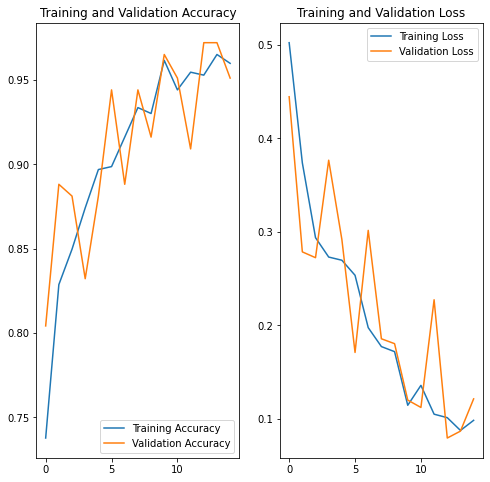

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
valid_loss,valid_acc = model.evaluate(valid_ds)
print(valid_loss)
print(valid_acc)

training_loss,training_acc = model.evaluate(training_ds)
print(training_loss)
print(training_acc)

8/8 [==============================] - 0s 56ms/step - loss: 0.1212 - accuracy: 0.9510
0.12124981731176376
0.9510489702224731
29/29 [==============================] - 2s 61ms/step - loss: 0.0945 - accuracy: 0.9545
0.09451618045568466
0.9545454382896423


Predict on new data

In [25]:
dataset_1 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/dataset1/normal/normal_0.png"
#test_ds = tf.keras.utils.get_file('sick', origin = dataset_1 )

img = tf.keras.utils.load_img(dataset_1, target_size=(100, 100))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to normal with a 100.00 percent confidence.


Found 50 files belonging to 1 classes.
Predictions:
 [0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


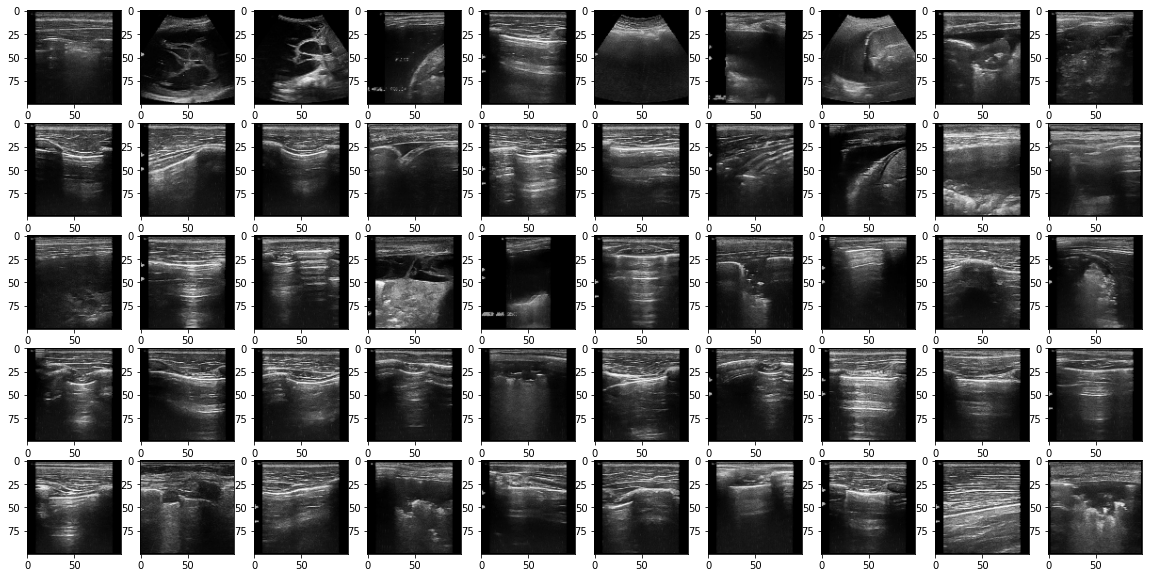

In [32]:
dataset_1 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/unknown_images"
test_ds = tf.keras.utils.image_dataset_from_directory(dataset_1, image_size=(100, 100), batch_size=50)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  

In [33]:
test_loss,test_acc = model.evaluate(test_ds)
print(test_loss)
print(test_acc)

1/1 [==============================] - 1s 719ms/step - loss: 3.4459 - accuracy: 0.5800
3.445852041244507
0.5799999833106995


Predict New Data from DataSet_2

In [34]:
dataset_2 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/dataset2"
test_ds2 = tf.keras.utils.image_dataset_from_directory(dataset_2, image_size=(100, 100), batch_size=20)

Found 224 files belonging to 1 classes.


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

test_ds2 = test_ds2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
normalization_layer = layers.Rescaling(1./255)

In [37]:
normalized_ds2 = test_ds2.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds2))
first_image = image_batch[3]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.86338294


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


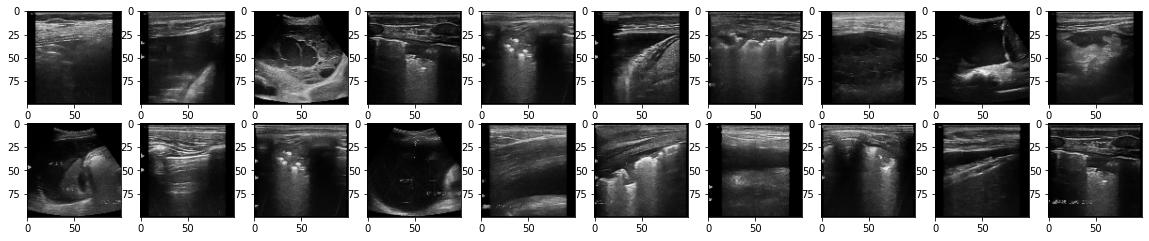

In [38]:


# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds2.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(20):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))

In [39]:
test_loss,test_acc = model.evaluate(test_ds2)
print(test_loss)
print(test_acc)

12/12 [==============================] - 1s 57ms/step - loss: 6.5189 - accuracy: 0.1339
6.518876075744629
0.1339285671710968
